In [1]:
import os
import re
import glob
import time
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import sentencepiece as spm
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio import SeqIO
import pandas as pd
import subprocess
import psutil
from joblib import delayed, Parallel

In [94]:

genome_sequences_dir = "genome_sequences"
tokenizers_dir = "tokenizers"
subsampled_genomes_dir = "subsampled_genomes"
os.makedirs(subsampled_genomes_dir, exist_ok=True)
os.makedirs(tokenizers_dir, exist_ok=True)  

#org = "Nanobdella_aerobiophila"
#org = 'Candidatus_Karelsulcia_muelleri'
#org = 'Ostreococcus_lucimarinus_CCE9901'
#org = 'Malassezia_restricta'
org = 'Theileria_orientalis_strain_Shintoku'
#org = 'Caenorhabditis_elegans'
genome_filename = f"{org.replace(' ', '_')}_cleaned.txt"


#org = "e_coli_genome"
#genome_filename = f"{org.replace(' ', '_')}_processed.txt"


#org = 'random_genome'
#genome_filename = f"{org.replace(' ', '_')}.txt"

def load_genome_sequence(filename):

    with open(os.path.join(genome_sequences_dir, filename), 'r') as f:
        genome = f.read().upper().replace('\n', '')
    return genome

genome = load_genome_sequence(genome_filename)
print(f"genome size: {len(genome)}")

#we need to chunk this size to run sentencepiece. I also added periods at the end of each line because sentencepiece was giving me errors without them
L = 4192

def process_genome_into_chunks(genome, path):
    chunks = [genome[i:i+L] + '.' for i in range(0, len(genome), L)]
    with open(path, 'w') as f:
        for chunk in chunks:
            f.write(chunk + '\n')
    print(f"processed genome saved to {path}")

processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
process_genome_into_chunks(genome, processed_genome_path)

def subsample_genome(genome, size=10**6):
    if len(genome) <= size:
        return genome  
    elif len(genome) <= 2 * size:
        return genome  
    return genome[:size] + genome[-size:]

def save_subsampled_genome(org, subsample):
    subsample_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_subsampled.txt")
    chunks = [subsample[i:i+L] + '.' for i in range(0, len(subsample), L)]
    with open(subsample_path, 'w') as f:
        for chunk in chunks:
            f.write(chunk + '\n')
    print(f"subsampled genome saved to {subsample_path}")
    return subsample_path

subsampled_sequence = subsample_genome(genome)
subsampled_genome_path = save_subsampled_genome(org, subsampled_sequence)


def check_processed_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        print(f"{path} contains {len(lines)} lines.")

check_processed_file(processed_genome_path)


def get_sequence_length(file_path):
    with open(file_path, 'r') as f:
        return len(f.read().replace('\n', ''))

processed_length = get_sequence_length(processed_genome_path)
subsampled_length = get_sequence_length(subsampled_genome_path)

print(f" processed genome length: {processed_length} bases")
print(f" ubsampled genome length: {subsampled_length} bases")

genome size: 9006764
processed genome saved to subsampled_genomes/Theileria_orientalis_strain_Shintoku_processed.txt
subsampled genome saved to subsampled_genomes/Theileria_orientalis_strain_Shintoku_subsampled.txt
subsampled_genomes/Theileria_orientalis_strain_Shintoku_processed.txt contains 2149 lines.
Length of processed genome: 9008913 bases
Length of subsampled genome: 2000478 bases


In [95]:
#generate kmers from the genome seq and calculate their frequencies

def generate_kmers(sequence, k):
    for i in range(len(sequence) - k + 1):
        yield sequence[i:i+k]

def calculate_kmer_frequencies(sequence, k):
    
    kmer_freqs = defaultdict(int)
    for kmer in generate_kmers(sequence, k):
        kmer_freqs[kmer] += 1
    
    return kmer_freqs

def create_vocabulary(kmer_freqs, vocab_size):
    sorted_kmers = sorted(kmer_freqs.items(), key=lambda x: x[1], reverse=True)
    vocab = [kmer for kmer, _ in sorted_kmers[:vocab_size]]
    return vocab

k = 6
kmer_freqs = calculate_kmer_frequencies(genome, k)

In [96]:
training_genome_path = processed_genome_path

#training_genome_path = subsampled_genome_path if subsampled_length < processed_length else processed_genome_path
#print(f"Using {'subsampled' if subsampled_length < processed_length else 'processed'} genome for training.")

def train_sentencepiece_tokenizer(input_file, model_prefix, vocab_size):
    try:
        spm.SentencePieceTrainer.train(
            input=input_file,
            model_prefix=model_prefix,
            vocab_size=vocab_size,
            model_type='bpe',
            character_coverage=0.9995,
            max_sentence_length=5000,
            hard_vocab_limit=False
        )
        if os.path.exists(model_prefix + ".model") and os.path.exists(model_prefix + ".vocab"):
            print(f"model and vocab files created: {model_prefix}.model, {model_prefix}.vocab")
        else:
            print(f"error, model or vocab file not created for {model_prefix}")
    except Exception as e:
        print(f"error occurred during training: {e}")
        raise e

def calculate_compression_factor(genome, tokens, vocab):
    total_length = len(genome)
    encoded_length = len(tokens)
    vocab_length = sum(len(token) for token in vocab)
    return (encoded_length + vocab_length) / total_length

def evaluate_vocab_size(vocab_size, genome, training_genome_path, kmer_freqs):
    model_prefix = os.path.join(tokenizers_dir, f"{org}_{vocab_size}")
    try:
        train_sentencepiece_tokenizer(training_genome_path, model_prefix, vocab_size)
    except RuntimeError as e:
        if "vocab size too high" in str(e):
            max_possible_vocab_size = int(str(e).split()[-1][:-1])
            if vocab_size > max_possible_vocab_size:
                vocab_size = max_possible_vocab_size
                try:
                    train_sentencepiece_tokenizer(training_genome_path, model_prefix, vocab_size)
                except RuntimeError as e:
                    return None
        else:
            raise e

    sp = spm.SentencePieceProcessor()
    sp.load(model_prefix + ".model")
    tokens = sp.encode_as_pieces(genome)
    vocab = [token for token, _ in kmer_freqs.items()][:vocab_size]
    compression_factor = calculate_compression_factor(genome, tokens, vocab)
    print(f'Vocab size: {vocab_size}, compression factor: {compression_factor}, number of tokens: {len(tokens)}')
    return vocab_size, compression_factor, len(tokens)

def evaluate_vocab_sizes(genome, training_genome_path, kmer_freqs, initial_vocab_size=1000, step_size=5000, max_vocab_size=60000):
    vocab_sizes = list(range(initial_vocab_size, max_vocab_size + step_size, step_size))
    with tqdm(total=len(vocab_sizes), desc="evaluating vocab sizes") as progress_bar:
        results = Parallel(n_jobs=-1)(
            delayed(evaluate_vocab_size)(vocab_size, genome, training_genome_path, kmer_freqs) 
            for vocab_size in vocab_sizes
        )
        for _ in results:
            progress_bar.update(1)
    return [result for result in results if result is not None]

def find_optimal_vocab_size(compression_factors, threshold=0.01):
    previous_factor = None
    optimal_size = None

    for vocab_size, factor, _ in sorted(compression_factors):
        if previous_factor is not None:
            change = factor - previous_factor
            if abs(change) < threshold:
                optimal_size = vocab_size
                break
        previous_factor = factor

    return optimal_size 

initial_vocab_size = 1000
step_size = 5000
max_vocab_size = 60000

compression_factors = evaluate_vocab_sizes(
    genome, training_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
)

optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
print(f"optimal vocab size for {org}: {optimal_vocab_size}")

evaluating vocab sizes:   0%|          | 0/11 [00:00<?, ?it/s]sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: subsampled_genomes/Theileria_orientalis_strain_Shintoku_processed.txt
  input_format: 
  model_prefix: tokenizers/Theileria_orientalis_strain_Shintoku_1000
  model_type: BPE
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 5000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_1000.model, tokenizers/Theileria_orientalis_strain_Shintoku_1000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=389 size=820 all=298681 active=22139 piece=AACTCG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=42 min_freq=6
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=299 size=1020 all=373609 active=25078 piece=GCACAA
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=232 min_freq=17
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=447 size=740 all=266006 active=28696 piece=ACATAG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=307 min_freq=21
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=347 min_freq=23
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=376 size=840 all=306645 active=30103 piece=ATTAATT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=42 size=4420 all=899845 active=46348 piece=TATAGTAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=290 size=1040 all=380629 active=32098 piece=GCCACC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=435 size=760 all=

Vocab size: 1000, compression factor: 0.23370002811220544, number of tokens: 2098881


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=143 size=1640 all=547160 active=35628 piece=TATTAATT
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: subsampled_genomes/Theileria_orientalis_strain_Shintoku_processed.txt
  input_format: 
  model_prefix: tokenizers/Theileria_orientalis_strain_Shintoku_41000
  model_type: BPE
  vocab_size: 41000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 5000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 0


model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_6000.model, tokenizers/Theileria_orientalis_strain_Shintoku_6000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=34 size=5240 all=956390 active=50161 piece=AGGAGTGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=35 size=5040 all=943498 active=49532 piece=AACTAGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=21 size=8040 all=1090267 active=55918 piece=ACATATTCG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=39 min_freq=6
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=34 size=5260 all=957641 active=51412 piece=TAAACTAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=21 size=8060 all=1090991 active=56642 piece=ATATATTCC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=35 size=5060 all=944828 active=50862 piece=ATTACCG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=2325 min_freq=309
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=34 size=5280 all=958890 active=52661 piece=TGTTAACG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=21 size=8080 all=1091701 active=57352 piece=TATGTGTAA
bpe_model_trainer.cc(268

Vocab size: 6000, compression factor: 0.19194951705185126, number of tokens: 1704268


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=30 size=5860 all=992572 active=52751 piece=ACCTTCTTC
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: subsampled_genomes/Theileria_orientalis_strain_Shintoku_processed.txt
  input_format: 
  model_prefix: tokenizers/Theileria_orientalis_strain_Shintoku_46000
  model_type: BPE
  vocab_size: 46000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 5000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 0


model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_11000.model, tokenizers/Theileria_orientalis_strain_Shintoku_11000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=14 size=11920 all=1204253 active=60648 piece=TTCTCCTTC
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=13 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=17 size=9420 all=1136871 active=57424 piece=TACGCTT
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=15 min_freq=4
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=13960 all=1247055 active=63047 piece=ATCTTAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=12 size=13340 all=1235374 active=62575 piece=TGGTTGTT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=14 size=11940 all=1204714 active=61109 piece=TTTTCTATT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=17 size=9440 all=1137509 active=58062 piece=TTACAAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=13980 all=1247468 active=63460 piece=TCGCTTG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=14 size=11960 all=1205143 active=61538 piece=ATTGTTAAAA
bpe_model_trainer.

Vocab size: 11000, compression factor: 0.18071518250061844, number of tokens: 1603083


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: subsampled_genomes/Theileria_orientalis_strain_Shintoku_processed.txt
  input_format: 
  model_prefix: tokenizers/Theileria_orientalis_strain_Shintoku_51000
  model_type: BPE
  vocab_size: 51000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 5000
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_16000.model, tokenizers/Theileria_orientalis_strain_Shintoku_16000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=10 size=16480 all=1290891 active=65692 piece=TTAAGTATG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=15020 all=1266943 active=63663 piece=TGGTAATAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=25 size=6860 all=1041804 active=54711 piece=TTGAGAAC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=9 size=16940 all=1297219 active=65457 piece=AGTGCTCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=9 size=17040 all=1298819 active=65536 piece=GCCCAGGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=25 size=6880 all=1042687 active=55594 piece=ATAAAATAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=10 size=16500 all=1291202 active=66003 piece=TTCCAGAAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=15040 all=1267290 active=64010 piece=TGTTCATTC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=9 size=16960 all=1297535 active=65773 piece=ATAGGAAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=25 size=6900 all=1043512 active=56

Vocab size: 16000, compression factor: 0.17402598758000098, number of tokens: 1542835


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=9 size=17540 all=1306508 active=65863 piece=ACTGACACG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=9 size=17560 all=1306789 active=66144 piece=ACTTGCTGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=9 size=17580 all=1307059 active=66414 piece=AGAGAGAGC
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=20 min_freq=4
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=9 size=17600 all=1307329 active=66684 piece=AGCCATATT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=8220 all=1096760 active=55510 piece=AGAGCGAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=8240 all=1097513 active=56263 piece=AGTGCCCC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=8260 all=1098253 active=57003 piece=ATGCTTTT
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=11 min_freq=3
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=9 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Ad

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_21000.model, tokenizers/Theileria_orientalis_strain_Shintoku_21000.vocab


bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=7 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=13980 all=1247468 active=63460 piece=TCGCTTG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=11 size=14000 all=1247874 active=63866 piece=AACCAAGG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=7 min_freq=3
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=8 min_freq=3
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=7 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=21920 all=1359012 active=68140 piece=ACCTTTGGG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=8 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=21940 all=1359220 active=68348 piece=ACGCGAACC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=8 size=19020 all=1325683 active=66534 piece=TATCCTCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=21520 all=1354649 acti

Vocab size: 21000, compression factor: 0.169242027436269, number of tokens: 1499747


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=22980 all=1369793 active=69242 piece=TGCTCCTCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=23100 all=1370980 active=69467 piece=TTATTTTGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=22700 all=1366949 active=69271 piece=TATAAATTC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=21220 all=1351025 active=67767 piece=GCAAAGGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=23000 all=1370002 active=69451 piece=TGGATAGAA
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=8 min_freq=3
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=10 min_freq=3
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=21240 all=1351262 active=68004 piece=GCCACCGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=8 size=20220 all=1340674 active=67261 piece=TCGACTGCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=21260 all=1351506 active=68248 piece=GCGACGGG
bpe_model_trainer.cc

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_26000.model, tokenizers/Theileria_orientalis_strain_Shintoku_26000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=24580 all=1383355 active=69926 piece=TTACCTAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=23680 all=1375551 active=69290 piece=TTTTAAATAC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=26320 all=1398283 active=70055 piece=TCTGTCAGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=24600 all=1383570 active=70141 piece=TTCCCTAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=7 size=23700 all=1375650 active=69389 piece=AGAGGAAGATG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=8 min_freq=3
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=6 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=26340 all=1398459 active=70231 piece=TGAACACAC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=8 size=19120 all=1327072 active=66601 piece=TGAAGTAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=26360 all=1398633 active=70405 piece=TGAATTGCG
bpe_model_trainer.

Vocab size: 26000, compression factor: 0.1655980993839741, number of tokens: 1466927


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=8 size=20020 all=1338308 active=67126 piece=TAAAGATTC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=25420 all=1390722 active=69698 piece=AGTTGACAA
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=6 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=27220 all=1404785 active=70327 piece=ATTTTCTGAA
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=6 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=8 size=20040 all=1338541 active=67359 piece=TAATCTTTT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=25440 all=1390891 active=69867 piece=ATAACTGAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=27240 all=1404881 active=70423 piece=GCCAGGAAGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=24620 all=1383772 active=69370 piece=TTGACGGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=8 size=20060 all=1338774 active=67592 piece=TACACTGTT
bpe_model_trainer

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_31000.model, tokenizers/Theileria_orientalis_strain_Shintoku_31000.vocab


bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=5 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=29580 all=1419885 active=71473 piece=AGCCCTGGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=28840 all=1414900 active=71049 piece=TTCGGCAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=24460 all=1382142 active=69659 piece=TCGGTTGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=28860 all=1415063 active=71212 piece=TTGATCGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=29600 all=1420032 active=71620 piece=AGCGATAAC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=30920 all=1428843 active=71565 piece=TCCGTGTAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=24480 all=1382344 active=69861 piece=TCTGGTCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=28880 all=1415219 active=71368 piece=TTGTACCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=28900 all=1415381 active=71530 piece=TTTTTCGC
bpe_m

Vocab size: 31000, compression factor: 0.1626105669028299, number of tokens: 1440019


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=29720 all=1420857 active=71158 piece=AGGTCAACC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=31840 all=1434765 active=71899 piece=ACAGATAAAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=25380 all=1390371 active=70166 piece=AGTCTGACC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=30480 all=1425921 active=71783 piece=TAACAGATC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=29740 all=1421001 active=71302 piece=AGGTGGTAC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=31860 all=1434846 active=71980 piece=ACCAAAACAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6 size=25400 all=1390543 active=70338 piece=AGTGTGACC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=30500 all=1426041 active=71903 piece=TAACTCTCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=29760 all=1421135 active=71436 piece=AGTACCTGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=31880 all=1434945 active=

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_36000.model, tokenizers/Theileria_orientalis_strain_Shintoku_36000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=34520 all=1445291 active=72380 piece=TCCGACGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=30020 all=1422878 active=71258 piece=ATCTACTTC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35120 all=1448586 active=72522 piece=ACAGAAAGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=34540 all=1445414 active=72503 piece=TCGGGATC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=30040 all=1423012 active=71392 piece=ATCTTTCCC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35140 all=1448679 active=72615 piece=ACAGGCCGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=34560 all=1445533 active=72622 piece=TCTATCCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=30060 all=1423153 active=71533 piece=ATGAGTCGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35160 all=1448771 active=72707 piece=ACATGTAAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=34580 all=1445657 active=72746

Vocab size: 36000, compression factor: 0.16008246691042421, number of tokens: 1417249


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35420 all=1450085 active=72599 piece=ACTATTTAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35940 all=1452679 active=72807 piece=AGTCCAGTC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=31020 all=1429527 active=71605 piece=TCTCCTGTT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35440 all=1450189 active=72703 piece=ACTCGAAGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35960 all=1452781 active=72909 piece=AGTCTTACC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=31040 all=1429655 active=71733 piece=TCTGGGAAG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35460 all=1450287 active=72801 piece=ACTGCACGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35980 all=1452881 active=73009 piece=AGTGCGCCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5 size=31060 all=1429782 active=71860 piece=TGAAAATGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=35480 all=1450391 active=72

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_41000.model, tokenizers/Theileria_orientalis_strain_Shintoku_41000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=36820 all=1457049 active=72941 piece=GCTGAGAGG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=36840 all=1457152 active=73044 piece=GCTGGTGGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=36860 all=1457247 active=73139 piece=GCTTGATGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=41120 all=1473684 active=73746 piece=TTAAGTTTCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=41140 all=1473730 active=73792 piece=TTATATATGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=36880 all=1457348 active=73240 piece=GGAGGCGAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=41160 all=1473778 active=73840 piece=TTCAAATCCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=36900 all=1457443 active=73335 piece=TAAAACCGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=41180 all=1473835 active=73897 piece=TTCATT

Vocab size: 41000, compression factor: 0.15786257972341675, number of tokens: 1397255


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42200 all=1475180 active=73824 piece=TGCGAATGTTG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=37900 all=1462345 active=73594 piece=TGAGCCCAA
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4 min_freq=2
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42220 all=1475194 active=73771 piece=TGGACCTCTCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=37920 all=1462455 active=73222 piece=TGATCACTT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42240 all=1475212 active=73789 piece=TGTAAACTATT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=37940 all=1462549 active=73316 piece=TGATTTTCC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42260 all=1475224 active=73801 piece=TGTGTAATTAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=37960 all=1462654 active=73421 piece=TGCAGAGGC
bpe_model_

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_46000.model, tokenizers/Theileria_orientalis_strain_Shintoku_46000.vocab


bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42740 all=1475210 active=73750 piece=TTGAATAAATAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42760 all=1475205 active=73745 piece=TTTATTTTTATT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42780 all=1475190 active=73730 piece=AACATTGTCTGCG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42800 all=1475172 active=73712 piece=ATAGCAGTAACAA
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42820 all=1475154 active=73741 piece=ATTTTAATATTTT
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42840 all=1475137 active=73724 piece=TATTTATTTATCC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42860 all=1475122 active=73709 piece=TTGCTCAGGGCGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42880 all=1475102 active=73689 piece=AGTTAGTGTATGAA
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4 size=42900 all=14750

Vocab size: 46000, compression factor: 0.15597888431405552, number of tokens: 1380289


bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=3 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=43920 all=1478922 active=74024 piece=TCTGATGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=43940 all=1479006 active=74108 piece=TGAGACGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=43960 all=1479084 active=74186 piece=TGCAGCGG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=43980 all=1479171 active=74273 piece=TGCGTATG
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=44000 all=1479258 active=74360 piece=TGGCGCGG
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=3 min_freq=2
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=44020 all=1479344 active=74044 piece=TGTAGATC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=44040 all=1479425 active=74125 piece=TGTTACGC
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3 size=44060 all=1479509 active=74209 piece=TTACCTGG
bpe_model_trainer.cc(268) 

model and vocab files created: tokenizers/Theileria_orientalis_strain_Shintoku_51000.model, tokenizers/Theileria_orientalis_strain_Shintoku_51000.vocab


evaluating vocab sizes: 100%|██████████| 11/11 [2:57:53<00:00, 970.33s/it]    

Vocab size: 51000, compression factor: 0.15431424649296907, number of tokens: 1365296
Optimal vocab size for Theileria_orientalis_strain_Shintoku: 16000


In [86]:

def load_and_tokenize(model_prefix, sequence):
    model_path = model_prefix + ".model"
    sp = spm.SentencePieceProcessor()
    print(f"Loading model from: {model_path}")
    sp.load(model_path) 
    tokens = sp.encode_as_pieces(sequence)
    print(f"Tokenization done. Num of tokens: {len(tokens)}")
    return tokens

# tokenize using optimal vocab size
model_prefix = os.path.join(tokenizers_dir, f"{org}_{optimal_vocab_size}")
tokens = load_and_tokenize(model_prefix, genome)


print(f"first 10 tokens: {tokens[1:11]}")

Loading model from: tokenizers/e_coli_genome_16000.model
Tokenization done. Num of tokens: 797770
first 10 tokens: ['AGCTTTTC', 'ATTC', 'TGACTGC', 'AACGG', 'GCAATATG', 'TCTCTGTG', 'TGGATT', 'AAAAAAAG', 'AGTG', 'TCTGATAGC']


In [72]:

for N in [1000, 41000, 81000]:
    model_path = f'{tokenizers_dir}/{org}_{N}.model'
    sp = spm.SentencePieceProcessor(model_file=model_path)
    
    print(f'vocab size: {N}')
    print('raw sequence:')
    print(genome[:100])
    print('tokenized sequence:')
    print(' '.join(sp.encode_as_pieces(genome[:100])[1:]))
    print('corresponding tokens:')
    print(' '.join([str(i) for i in sp.encode(genome[:100])[1:]]))
    print('num of tokens in genome:', len(sp.encode_as_pieces(genome)))
    print()

vocab size: 1000
raw sequence:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT
tokenized sequence:
AGC TTTTC ATTC TGAC TGC AACGG GCAA TATG TC TCTG TG TGGATT AAAA AAAG AGTG TCTG ATAGC AGC TTCTG AACTGG TTACC TGCCG TGAG TAA AT
corresponding tokens:
20 102 42 142 21 159 46 88 6 80 8 558 33 85 92 80 249 20 253 329 194 114 198 24 14
num of tokens in genome: 1077459

vocab size: 41000
raw sequence:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT
tokenized sequence:
AGCTTTTC ATTCTGAC TGCAACGG GCAATATG TCTCTGTG TGGATT AAAAAAAG AGTGTCTG ATAGC AGCTTCTG AACTGG TTACCTGCCG TGAGTAA AT
corresponding tokens:
8692 10726 36855 3772 36793 558 4267 25325 249 35869 329 32803 4954 14
num of tokens in genome: 705749

vocab size: 81000
raw sequence:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT
tokenized sequence:
AGCTTTTC ATTCTGAC TGCAACGG GCAATATG TC

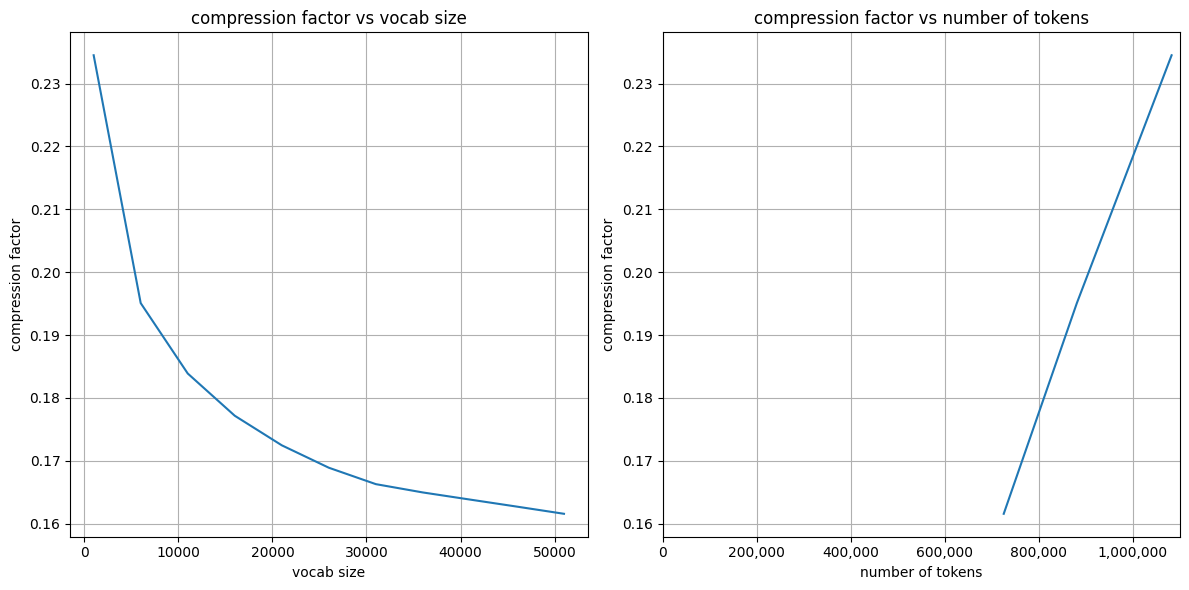

In [87]:
import matplotlib.ticker as mticker


def plot_results(compression_factors):
    vocab_sizes, compression_values, num_tokens = zip(*compression_factors)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(vocab_sizes, compression_values)
    plt.xlabel('vocab size')
    plt.ylabel('compression factor')
    plt.title('compression factor vs vocab size')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(num_tokens, compression_values)
    plt.xlabel('number of tokens')
    plt.ylabel('compression factor')
    plt.title('compression factor vs number of tokens')
    plt.grid(True)
    plt.xlim(left=0)
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.tight_layout()
    plt.show()

plot_results(compression_factors)

[('GCC', 21351), ('GGC', 19786), ('GC', 16574), ('GAC', 13083), ('AC', 10580), ('GCT', 9479), ('GTC', 9364), ('AGC', 9036), ('GGT', 8673), ('GTT', 8199), ('AAC', 6999), ('GT', 6979), ('ACC', 6743), ('GACC', 6545), ('CGT', 6519), ('CAG', 6406), ('ATC', 6256), ('GCGG', 5881), ('AACC', 5860), ('GGTT', 5789), ('GTTT', 5635), ('GAT', 5505), ('GAAC', 5225), ('GG', 5171), ('CCC', 5140), ('CC', 5094), ('CGG', 5085), ('CTGG', 4915), ('CGC', 4881), ('CAC', 4785)]


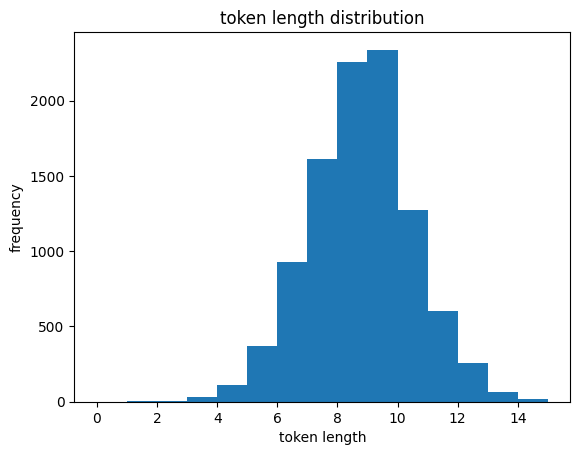

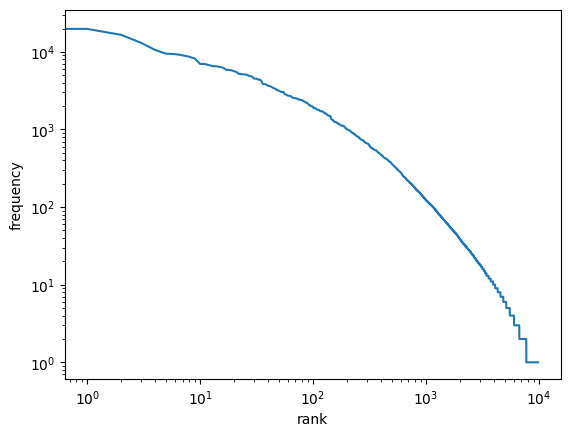

In [74]:
#note that the max token length specified is either 16 or 32 so it won't go past whichever value you  specify

#org = 'e_coli_genome'
#org = 'Malassezia_restricta'
org = 'Nanobdella_aerobiophila'
best_model_path = f'{tokenizers_dir}/{org}_{optimal_vocab_size}.model'
sp = spm.SentencePieceProcessor(model_file=best_model_path)

tokens = sp.encode_as_pieces(genome)
tokcounts = Counter(tokens).most_common()
print(tokcounts[:30])

plt.hist([len(t[0]) for t in tokcounts],
        bins=np.arange(0,max([len(t[0]) for t in tokcounts])+1))
plt.xlabel('token length')
plt.ylabel('frequency')
plt.title('token length distribution')
plt.show()

TC = [t[1] for t in tokcounts]
plt.plot(np.arange(0, len(TC), 1), TC)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('frequency')
plt.show()

In [ ]:
#run for all organisms

organisms = [
    "Nanobdella aerobiophila",
    "Candidatus Karelsulcia muelleri",
    "Malassezia restricta",
    "Caenorhabditis elegans",
    "Ostreococcus lucimarinus CCE9901",
    "Theileria orientalis strain Shintoku",
    "Rice yellow mottle virus satellite"
]


def process_organism(org):
    genome_filename = f"{org.replace(' ', '_')}_cleaned.txt"
    genome = load_genome_sequence(genome_filename)
    
    L = 4192
    processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
    process_genome_into_chunks(genome, processed_genome_path)
    
    k = 6
    kmer_freqs = calculate_kmer_frequencies(genome, k)
    
    initial_vocab_size = 1000
    step_size = 12000
    max_vocab_size = 80000
    compression_factors = evaluate_vocab_sizes(
        genome, processed_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
    )
    
    optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
    print(f"Optimal vocab size for {org}: {optimal_vocab_size}")

    plot_results(compression_factors)
    
    best_model_path = f'{tokenizers_dir}/{org}_{optimal_vocab_size}.model'
    sp = spm.SentencePieceProcessor(model_file=best_model_path)

    tokens = sp.encode_as_pieces(genome)
    tokcounts = Counter(tokens).most_common()
    print(tokcounts[:30])

    plt.hist([len(t[0]) for t in tokcounts], bins=np.arange(0, max([len(t[0]) for t in tokcounts]) + 1))
    plt.xlabel('Token length')
    plt.ylabel('Frequency')
    plt.title(f'Token Length Distribution for {org}')
    plt.show()

    TC = [t[1] for t in tokcounts]
    plt.plot(np.arange(0, len(TC), 1), TC)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title(f'Rank-Frequency Curve for {org}')
    plt.show()

for org in organisms:
    print(f"Processing {org}...")
    process_organism(org)

In [ ]:
# """
# Compare different k values for kmer analysis and evaluate their impact on tokenization. I haven't had the chance to fully run it yet though
# """

# def calculate_compression_factor(genome, tokens, vocab):
#     total_length = len(genome)
#     encoded_length = len(tokens)
#     vocab_length = sum(len(token) for token in vocab)
#     compression_factor = (encoded_length + vocab_length) / total_length
#     return compression_factor

# def evaluate_vocab_sizes(genome, processed_genome_path, kmer_freqs, initial_vocab_size=1000, step_size=10000, max_vocab_size=80000):
#     vocab_sizes = list(range(initial_vocab_size, max_vocab_size + step_size, step_size))
#     compression_factors = []

#     # go thru each vocab size and train tokenizer, calculate compression factor
#     for vocab_size in tqdm(vocab_sizes):
#         model_prefix = os.path.join(tokenizers_dir, f"{org}_{vocab_size}")
#         try:
#             train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
#         except RuntimeError as e:
#             if "vocab size too high" in str(e):
#                 max_possible_vocab_size = int(str(e).split()[-1][:-1])
#                 if vocab_size > max_possible_vocab_size:
#                     vocab_size = max_possible_vocab_size
#                     try:
#                         train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
#                     except RuntimeError as e:
#                         continue
#             else:
#                 raise e

#         sp = spm.SentencePieceProcessor()
#         sp.load(model_prefix + ".model")
#         tokens = sp.encode_as_pieces(genome)
        
#         #use kmer frequencies to create a vocab list and calculate the compression factor
#         vocab = [token for token, _ in kmer_freqs.items()][:vocab_size]
#         compression_factor = calculate_compression_factor(genome, tokens, vocab)
#         compression_factors.append((vocab_size, compression_factor, len(tokens)))
#         print(f'vocab size: {vocab_size}, compression factor: {compression_factor}, number of tokens: {len(tokens)}')

#     return compression_factors

# #find optimal vocab size based on the compression factors
# def find_optimal_vocab_size(compression_factors, threshold=0.01):
#     previous_factor = None
#     optimal_size = None

#     for vocab_size, factor, _ in sorted(compression_factors):
#         if previous_factor is not None:
#             change = factor - previous_factor
#             if abs(change) < threshold:
#                 optimal_size = vocab_size
#                 break
#         previous_factor = factor

#     return optimal_size if optimal_size else max(compression_factors, key=lambda x: x[1])[0]



# initial_vocab_size = 1000
# step_size = 12000
# max_vocab_size = 80000

# compression_factors = evaluate_vocab_sizes(
#     genome, processed_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
# )

# optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
# print(f"optimal vocab size for {org}: {optimal_vocab_size}")



# # evaluate kmer frequencies and compression factors for dif k values
# def evaluate_k_values(genome, processed_genome_path, k_values, initial_vocab_size=1000, step_size=12000, max_vocab_size=80000):
#     results = {}
#     for k in k_values:
#         print(f"Evaluating k={k}")
#         kmer_freqs = calculate_kmer_frequencies(genome, k)
#         compression_factors = evaluate_vocab_sizes(
#             genome, processed_genome_path, kmer_freqs, initial_vocab_size, step_size, max_vocab_size
#         )
#         optimal_vocab_size = find_optimal_vocab_size(compression_factors, threshold=0.01)
#         results[k] = {
#             "optimal_vocab_size": optimal_vocab_size,
#             "compression_factors": compression_factors
#         }
#         print(f"Optimal vocab size for k={k}: {optimal_vocab_size}")
#     return results

# k_vals = [3,4,6,21,41,61,121]

# L = 4192
# processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
# process_genome_into_chunks(genome, processed_genome_path)

# results = evaluate_k_values(genome, processed_genome_path, k_vals)

# for k in k_vals:
#     print(f"plotting results for k={k}")
#     compression_factors = results[k]["compression_factors"]
#     plot_results(compression_factors)
#     optimal_vocab_size = results[k]["optimal_vocab_size"]
#     print(f"optimal vocab size for k={k}: {optimal_vocab_size}")

 12%|█▎        | 1/8 [00:14<01:39, 14.16s/it]

Starting training for vocab size: 1000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_1000.model
Output vocab file: tokenizers/e_coli_genome_1000.vocab
model & vocab files created: tokenizers/e_coli_genome_1000.model, tokenizers/e_coli_genome_1000.vocab
training done successfully.
vocab size: 1000, compression factor: 0.23342108948326565, number of tokens: 1077459
Starting training for vocab size: 13000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_13000.model
Output vocab file: tokenizers/e_coli_genome_13000.vocab


 25%|██▌       | 2/8 [00:52<02:49, 28.24s/it]

model & vocab files created: tokenizers/e_coli_genome_13000.model, tokenizers/e_coli_genome_13000.vocab
training done successfully.
vocab size: 13000, compression factor: 0.17877802074693266, number of tokens: 805249
Starting training for vocab size: 25000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_25000.model
Output vocab file: tokenizers/e_coli_genome_25000.vocab
model & vocab files created: tokenizers/e_coli_genome_25000.model, tokenizers/e_coli_genome_25000.vocab
training done successfully.
vocab size: 25000, compression factor: 0.16642487046632123, number of tokens: 747910


 50%|█████     | 4/8 [03:50<04:45, 71.43s/it]

Starting training for vocab size: 37000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_37000.model
Output vocab file: tokenizers/e_coli_genome_37000.vocab
model & vocab files created: tokenizers/e_coli_genome_37000.model, tokenizers/e_coli_genome_37000.vocab
training done successfully.
vocab size: 37000, compression factor: 0.15906498766602395, number of tokens: 713748
Starting training for vocab size: 49000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_49000.model
Output vocab file: tokenizers/e_coli_genome_49000.vocab
model & vocab files created: tokenizers/e_coli_genome_49000.model, tokenizers/e_coli_genome_49000.vocab
training done successfully.
vocab size: 49000, compression factor: 0.15389656695356177, number of tokens: 689758


 75%|███████▌  | 6/8 [10:57<05:13, 156.89s/it]

Starting training for vocab size: 61000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_61000.model
Output vocab file: tokenizers/e_coli_genome_61000.vocab
model & vocab files created: tokenizers/e_coli_genome_61000.model, tokenizers/e_coli_genome_61000.vocab
training done successfully.
vocab size: 61000, compression factor: 0.14873460945999806, number of tokens: 665798
Starting training for vocab size: 73000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_73000.model
Output vocab file: tokenizers/e_coli_genome_73000.vocab
model & vocab files created: tokenizers/e_coli_genome_73000.model, tokenizers/e_coli_genome_73000.vocab
training done successfully.
vocab size: 73000, compression factor: 0.14560942768196655, number of tokens: 651292


100%|██████████| 8/8 [22:19<00:00, 167.38s/it]

Starting training for vocab size: 85000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_85000.model
Output vocab file: tokenizers/e_coli_genome_85000.vocab
model & vocab files created: tokenizers/e_coli_genome_85000.model, tokenizers/e_coli_genome_85000.vocab
training done successfully.
vocab size: 85000, compression factor: 0.14304072905109175, number of tokens: 639369
optimal vocab size for e_coli_genome: 37000
processed genome saved to subsampled_genomes/e_coli_genome_processed.txt
Evaluating k=3



 12%|█▎        | 1/8 [00:14<01:41, 14.45s/it]

Starting training for vocab size: 1000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_1000.model
Output vocab file: tokenizers/e_coli_genome_1000.vocab
model & vocab files created: tokenizers/e_coli_genome_1000.model, tokenizers/e_coli_genome_1000.vocab
training done successfully.
vocab size: 1000, compression factor: 0.23216981030452533, number of tokens: 1077459
Starting training for vocab size: 13000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_13000.model
Output vocab file: tokenizers/e_coli_genome_13000.vocab


 25%|██▌       | 2/8 [00:52<02:49, 28.28s/it]

model & vocab files created: tokenizers/e_coli_genome_13000.model, tokenizers/e_coli_genome_13000.vocab
training done successfully.
vocab size: 13000, compression factor: 0.17352471642627082, number of tokens: 805249
Starting training for vocab size: 25000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_25000.model
Output vocab file: tokenizers/e_coli_genome_25000.vocab
model & vocab files created: tokenizers/e_coli_genome_25000.model, tokenizers/e_coli_genome_25000.vocab
training done successfully.
vocab size: 25000, compression factor: 0.16117156614565942, number of tokens: 747910


 50%|█████     | 4/8 [04:04<05:04, 76.21s/it]

Starting training for vocab size: 37000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_37000.model
Output vocab file: tokenizers/e_coli_genome_37000.vocab
model & vocab files created: tokenizers/e_coli_genome_37000.model, tokenizers/e_coli_genome_37000.vocab
training done successfully.
vocab size: 37000, compression factor: 0.1538116833453621, number of tokens: 713748
Starting training for vocab size: 49000
Input file: subsampled_genomes/e_coli_genome_processed.txt
Output model file: tokenizers/e_coli_genome_49000.model
Output vocab file: tokenizers/e_coli_genome_49000.vocab
model & vocab files created: tokenizers/e_coli_genome_49000.model, tokenizers/e_coli_genome_49000.vocab
training done successfully.
vocab size: 49000, compression factor: 0.14864326263289993, number of tokens: 689758
